## Import relevant packages

In [1]:
import pandas as pd
import numpy as np
#
from nltk.corpus import stopwords 
import nltk.tokenize as nltk
from sklearn.model_selection import train_test_split
#
import pickle
import xgboost
import re

## Correct messy encoding

Run if data contains weird symbols for punctuation (i.e. â€™ instead of ' )

In [3]:
import csv
import ftfy


# input file
csvfile = open('C:\\Users\\Jasmine.Ooi\\Downloads\\single_issue3.csv', "r", encoding = "UTF8")
reader = csv.DictReader(csvfile)

# output stream
outfile = open('C:\\Users\\Jasmine.Ooi\\Desktop\\single_issue_4.csv', "w", encoding = "utf-8") # Windows doesn't like utf8
writer = csv.DictWriter(outfile, fieldnames = reader.fieldnames, lineterminator = "\n")

# clean values
writer.writeheader()
for row in reader:
    for col in row:
        row[col] = ftfy.fix_text(row[col])
    writer.writerow(row)

# close files
csvfile.close()
outfile.close()


    


## Load data in

In [150]:
train = pd.read_csv('C:\\Users\\Jasmine.Ooi\\Desktop\\single_issue_4.csv', encoding = "utf-8")
train.drop(['issue_2','issue_3','issue_2_new','issue_3_new', 'Language','Translation'], axis=1, inplace = True)

train.head()

,tracking_number,nps_rating,feedback,issue_1,country,issue_1_new
0,AFA146167A,5,parcel in good condition.ninja could have been...,Driver - Rude/Poor attitude,sg,D4
1,AFA147716A,6,not very approachable,Driver - Rude/Poor attitude,sg,D4
2,CK-SG1806300877,5,ninja came up to pte condo unit without inform...,Driver - No call before OFD,sg,D5
3,CK-SG1807010255,1,"the delivery man was too bad in communication,...",Driver - Rude/Poor attitude,sg,D4
4,CK-SG1807140621,1,they said that theyll be at my place so they t...,Driver - Did not deliver to doorstep,sg,D1


Remove \r and \n tags

In [152]:
train['feedback'] = train['feedback'].str.replace(r'(?<![a-zA-Z0-9])\r\n', '')
train['feedback'] = train['feedback'].str.replace(r'\r\n(?![a-zA-Z0-9])', '')
train['feedback'] = train['feedback'].str.replace(r'[\r\n]', ' ')

train['feedback'].head()


0    parcel in good condition.ninja could have been...
1                                not very approachable
2    ninja came up to pte condo unit without inform...
3    the delivery man was too bad in communication,...
4    they said that theyll be at my place so they t...
Name: feedback, dtype: object

## Replace punctuation

Replaced all punctuation with a space, except for apostrophes. Apostrophes that are not preceded and followed by an alphanumeric character are removed. Apostrophes that are preceded and followed by alphanumeric characters are preserved for contractions processing.

In [153]:
train['feedback'] = train['feedback'].str.replace(r'[^\w\s{P}\']+', ' ')
train['feedback'] = train['feedback'].str.replace(r'(?<![a-zA-Z])\'', '')
train['feedback'] = train['feedback'].str.replace(r'\'(?![a-zA-Z])', '')

In [154]:
train['feedback'].head()

0    parcel in good condition ninja could have been...
1                                not very approachable
2    ninja came up to pte condo unit without inform...
3    the delivery man was too bad in communication ...
4    they said that theyll be at my place so they t...
Name: feedback, dtype: object

## Delete weird characters

In [155]:
train['feedback'] = train['feedback'].str.replace("([^\x00-\x7F])+", '')

## Delete numbers 

In [156]:
train['feedback'] = train['feedback'].str.replace('\d+', '')

## Strip leading and trailing whitespaces

In [157]:
train['feedback'] = train['feedback'].str.strip()

In [158]:
train['feedback'].head()

0    parcel in good condition ninja could have been...
1                                not very approachable
2    ninja came up to pte condo unit without inform...
3    the delivery man was too bad in communication ...
4    they said that theyll be at my place so they t...
Name: feedback, dtype: object

## Assigning code for blank feedback

In [159]:
train['feedback'].isnull().sum()

3

In [160]:
train['feedback'].fillna('xyz', inplace = True)

Random check on text:

In [161]:
print(train['feedback'][100:120])

100    delivery guy called me but i didnt pick up  wi...
101                                     not professional
102    customer service officer can't help to solve t...
103    guy complained he couldnt get there in time  t...
104       this time round he is quite rude and impatient
105    this is the second time they never call my con...
106    claimed that my doorbell isn't working when i ...
107                           they dun pick up call rite
108                                        poor attitude
109       didnt call when couldnt get in to the building
110    selected blk  for collection ended up delivere...
111    there was two person that came to my house to ...
112    mainly on delivery timeline  failed delivery t...
113    i don't want to have to collect it i expect th...
114                         delivered to wrong apartment
115                                                 rude
116    it was suppossed to be delivered to my office ...
117          the person knock a

## Expand contractions

Convert contractions such as "don't" and "wasn't" to their full forms

In [162]:
from pycontractions import Contractions
cont = Contractions(api_key="glove-twitter-100")

In [163]:
feedback1 = pd.Series(list(cont.expand_texts(train['feedback'])))

In [164]:
train1 = pd.concat([train,feedback1], axis = 1)

In [165]:
train1.drop('feedback', axis=1, inplace=True)
train1.rename(columns = {0:'feedback'},inplace = True)
train1.head()

,tracking_number,nps_rating,issue_1,country,issue_1_new,feedback
0,AFA146167A,5,Driver - Rude/Poor attitude,sg,D4,parcel in good condition ninja could have been...
1,AFA147716A,6,Driver - Rude/Poor attitude,sg,D4,not very approachable
2,CK-SG1806300877,5,Driver - No call before OFD,sg,D5,ninja came up to pte condo unit without inform...
3,CK-SG1807010255,1,Driver - Rude/Poor attitude,sg,D4,the delivery man was too bad in communication ...
4,CK-SG1807140621,1,Driver - Did not deliver to doorstep,sg,D1,they said that they will be at my place so the...


<b> Before: </b>

In [166]:
print(train[train['tracking_number']=='CK-SG1901300018']['feedback'])

1017    people who working we can't collect personally...
Name: feedback, dtype: object


<b> After: </b>

In [167]:
print(train1[train1['tracking_number']=='CK-SG1901300018']['feedback'])

1017    people who working we cannot collect personall...
Name: feedback, dtype: object


## Tokenise the feedback column

In [168]:
train1["feedback"] = train1["feedback"].apply(nltk.word_tokenize)

In [169]:
train1.head()

,tracking_number,nps_rating,issue_1,country,issue_1_new,feedback
0,AFA146167A,5,Driver - Rude/Poor attitude,sg,D4,"[parcel, in, good, condition, ninja, could, ha..."
1,AFA147716A,6,Driver - Rude/Poor attitude,sg,D4,"[not, very, approachable]"
2,CK-SG1806300877,5,Driver - No call before OFD,sg,D5,"[ninja, came, up, to, pte, condo, unit, withou..."
3,CK-SG1807010255,1,Driver - Rude/Poor attitude,sg,D4,"[the, delivery, man, was, too, bad, in, commun..."
4,CK-SG1807140621,1,Driver - Did not deliver to doorstep,sg,D1,"[they, said, that, they, will, be, at, my, pla..."


## Remove typos

Removing excessive letters (i.e. more than 2 letters of the same kind in a row)

In [170]:
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [171]:
train1['feedback'] = train1['feedback'].apply(lambda x: [reduce_lengthening(x[i]) for i in range(len(x)) ])

In [172]:
train1['feedback'].head()

0    [parcel, in, good, condition, ninja, could, ha...
1                            [not, very, approachable]
2    [ninja, came, up, to, pte, condo, unit, withou...
3    [the, delivery, man, was, too, bad, in, commun...
4    [they, said, that, they, will, be, at, my, pla...
Name: feedback, dtype: object

<br>
Manual removal of contextual typos (Ninja, Sephora, Zalora)

In [173]:
def correct_manual(text):
    pattern1 = re.compile(r"ni.*j.*a")
    pattern2 = re.compile(r"s.{1,3}[pf].*ra")
    pattern3 = re.compile(r"z.{1,3}l.*r[ae]")
    if re.match(pattern1,text) != None:
        return pattern1.sub('ninja', text)
    elif re.match(pattern2,text) != None:
        return pattern2.sub('sephora', text)
    elif re.match(pattern3, text) != None:
        return pattern3.sub('zalora', text)
    else:
        return text
    

In [174]:
train1['feedback'] = train1['feedback'].apply(lambda x: [correct_manual(x[i]) for i in range(len(x)) ])

<br>
Manual removal of non-English words

In [175]:
nonenglish_words = ['aku','saya','beliau','kami','dari','anot','ke','yang','untuk','di','walaupun','apa','sahaja','saja','dalam','dlm','dia','mereka','sudah','sdh','tetapi','tapi','lah','lor','sia','knp','kenapa','liddat','blm','belum','walau','tu','dah','dahlah']


In [176]:
train1['feedback'] = train1['feedback'].apply(lambda x: [item for item in x if item not in nonenglish_words])

<br>
Automated spellcheck (Not using as of now because of high % of localised slang)

In [87]:
# from spellchecker import SpellChecker
# spell = SpellChecker()

# # find those words that may be misspelled
# misspelled = spell.unknown(['corier', 'hariraya', 'correspondent', 'couldnnt'])

# for word in misspelled:
#     # Get the one `most likely` answer
#     print(spell.correction(word))

#     # Get a list of `likely` options
#     print(spell.candidates(word))

corner
{'courier', 'cosier', 'corker', 'corner', 'copier', 'correr', 'corder', 'crier'}
harray
{'harray'}
couldnt
{'couldnt', "couldn't"}


## Remove stopwords

In [177]:
stop_words = stopwords.words("english")
# print(stop_words)
stop_words = [e for e in stop_words if e not in ('not','no','only','once','few','after','before','during','until')]
stop_words = [e for e in stop_words if "'" not in e]
additional_sw = ['simply','guys','yall','courier','please','totally','may','almost','nearly','maybe', 'I']
stop_words = stop_words + additional_sw
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'more', 'most', 'other', 'some', 'such', 'nor', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn',

In [178]:
train1['feedback'] = train1['feedback'].apply(lambda x: [item for item in x if item not in stop_words])

## Check no. of words

Has the number of words been reduced significantly?

In [179]:
totalwords = train1['feedback'].explode().reset_index(drop = True).tolist()
print(len(totalwords))
print(len(set(totalwords)))

206389
8330


In [180]:
from nltk.probability import FreqDist
freqdist = FreqDist(totalwords)
print(freqdist)

<FreqDist with 8330 samples and 206389 outcomes>


<br>
<b> All the words present in the data: </b>

In [ ]:
freqdist.keys()

<br>
<b> Top 50 most comon words: </b>

In [181]:
freqdist.most_common(50)

[('delivery', 10243),
 ('not', 8575),
 ('parcel', 5736),
 ('time', 3491),
 ('no', 2696),
 ('call', 2166),
 ('delivered', 2116),
 ('pm', 2009),
 ('ninja', 1989),
 ('service', 1974),
 ('day', 1905),
 ('home', 1801),
 ('deliver', 1667),
 ('received', 1614),
 ('item', 1498),
 ('door', 1312),
 ('customer', 1243),
 ('only', 1115),
 ('even', 1089),
 ('late', 1051),
 ('before', 1042),
 ('one', 1026),
 ('receive', 999),
 ('called', 980),
 ('van', 967),
 ('good', 945),
 ('after', 932),
 ('days', 887),
 ('driver', 871),
 ('address', 852),
 ('package', 830),
 ('person', 818),
 ('would', 806),
 ('staff', 795),
 ('house', 780),
 ('left', 774),
 ('man', 744),
 ('guy', 734),
 ('wait', 733),
 ('sms', 704),
 ('reason', 679),
 ('first', 675),
 ('without', 657),
 ('could', 648),
 ('office', 646),
 ('never', 629),
 ('get', 628),
 ('slow', 626),
 ('said', 617),
 ('rude', 602)]

<br>
<b> Top 500 least frequent words: </b>

In [182]:
freqdist.most_common()[-500:-1]

[('feign', 1),
 ('bm', 1),
 ('coast', 1),
 ('delibery', 1),
 ('slim', 1),
 ('cyberjaya', 1),
 ('tensed', 1),
 ('depart', 1),
 ('wright', 1),
 ('refundable', 1),
 ('maghrib', 1),
 ('miscommunicate', 1),
 ('foolish', 1),
 ('superb', 1),
 ('utm', 1),
 ('afiq', 1),
 ('signiture', 1),
 ('fool', 1),
 ('pocketed', 1),
 ('reliased', 1),
 ('pg', 1),
 ('addressagain', 1),
 ('liners', 1),
 ('sahar', 1),
 ('solely', 1),
 ('respecting', 1),
 ('fullfiled', 1),
 ('unreached', 1),
 ('thrilled', 1),
 ('dropbox', 1),
 ('moody', 1),
 ('overlooked', 1),
 ('brainstorming', 1),
 ('verry', 1),
 ('unprofesional', 1),
 ('song', 1),
 ('recommeded', 1),
 ('lols', 1),
 ('telephonr', 1),
 ('tome', 1),
 ('fren', 1),
 ('vodoo', 1),
 ('thin', 1),
 ('connaught', 1),
 ('pdn', 1),
 ('perdana', 1),
 ('cel', 1),
 ('melia', 1),
 ('defected', 1),
 ('hireoku', 1),
 ('devilry', 1),
 ('emel', 1),
 ('tudung', 1),
 ('unacceptably', 1),
 ('attitube', 1),
 ('snack', 1),
 ('sweating', 1),
 ('aby', 1),
 ('ignorant', 1),
 ('embarrass

Rejoin words into a string for parsing into model

In [183]:
train1['feedback2'] = train1["feedback"].str.join(" ")

In [184]:
train1.head()

,tracking_number,nps_rating,issue_1,country,issue_1_new,feedback,feedback2
0,AFA146167A,5,Driver - Rude/Poor attitude,sg,D4,"[parcel, good, condition, ninja, could, polite...",parcel good condition ninja could polite ringi...
1,AFA147716A,6,Driver - Rude/Poor attitude,sg,D4,"[not, approachable]",not approachable
2,CK-SG1806300877,5,Driver - No call before OFD,sg,D5,"[ninja, came, pte, condo, unit, without, infor...",ninja came pte condo unit without informing gu...
3,CK-SG1807010255,1,Driver - Rude/Poor attitude,sg,D4,"[delivery, man, bad, communication, unpatient,...",delivery man bad communication unpatient told ...
4,CK-SG1807140621,1,Driver - Did not deliver to doorstep,sg,D1,"[said, place, told, come, went, rushing, wait,...",said place told come went rushing wait mins


## Train Test Split

In [185]:
X_train, X_val, y_train, y_val = train_test_split(train1['feedback2'], train1['issue_1_new'])

## Vectorise

In [186]:
## Potential vectoriser to be explored
# import skipthoughts
 
# class SkipThoughtsVectorizer(object):
#     def __init__(self, **kwargs):
#         self.model = skipthoughts.load_model()
#         self.encoder = skipthoughts.Encoder(self.model)
 
#     def fit_transform(self, raw_documents, y):
#         return self.encoder.encode(raw_documents, verbose=False)
 
#     def fit(self, raw_documents, y=None):
#         self.fit_transform(raw_documents, y)
#         return self
 
#     def transform(self, raw_documents, copy=True):
#         return self.fit_transform(raw_documents, None)

In [187]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()

In [188]:
X_train_vect = vect.fit_transform(X_train)
X_val_vect = vect.transform(X_val)

## Selecting classifiers: 

In [189]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Naive Bayes

In [190]:
from sklearn.naive_bayes import MultinomialNB
model1 = MultinomialNB()

In [191]:
model1.fit(X_train_vect, y_train)

MultinomialNB()

In [192]:
y_predict1 = model1.predict(X_val_vect)

In [193]:
print('Accuracy score: {}%'.format(accuracy_score(y_val, y_predict1) * 100))
print(20*'-')
print(classification_report(y_val, y_predict1))

Accuracy score: 52.277542372881356%
--------------------
              precision    recall  f1-score   support

          D1       0.73      0.10      0.18       191
          D2       0.00      0.00      0.00       114
          D3       0.91      0.12      0.22       234
          D4       0.53      0.88      0.66       624
          D5       0.00      0.00      0.00       155
          D6       0.00      0.00      0.00         7
          I0       0.96      0.11      0.20       377
          N0       0.00      0.00      0.00       139
          P1       0.00      0.00      0.00        85
          P2       0.73      0.40      0.52       115
          P3       0.62      0.66      0.64       507
          P4       0.42      0.93      0.58       830
          P5       0.50      0.01      0.02        79
          P6       0.00      0.00      0.00        19
          W0       0.92      0.60      0.72       300

    accuracy                           0.52      3776
   macro avg       0.42

C:\Users\Jasmine.Ooi\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [194]:
print(confusion_matrix(y_val, y_predict1))

[[ 19   0   0 114   0   0   0   0   0   0   4  54   0   0   0]
 [  2   0   3  27   0   0   0   0   0   0   3  78   0   0   1]
 [  0   0  29  88   0   0   0   0   0   0  15 102   0   0   0]
 [  0   0   0 552   0   0   0   0   0   1  12  57   0   0   2]
 [  0   0   0  45   0   0   0   0   0   0  50  60   0   0   0]
 [  0   0   0   2   0   0   0   0   0   0   1   4   0   0   0]
 [  2   0   0  62   0   0  43   0   0   0  37 224   1   0   8]
 [  3   0   0  18   0   0   0   0   0  16   7  95   0   0   0]
 [  0   0   0  19   0   0   0   0   0   0  10  55   0   0   1]
 [  0   0   0  33   0   0   0   0   0  46   1  35   0   0   0]
 [  0   0   0  25   0   0   0   0   0   0 333 148   0   0   1]
 [  0   0   0  23   0   0   0   0   0   0  32 772   0   0   3]
 [  0   0   0  16   0   0   1   0   0   0  14  47   1   0   0]
 [  0   0   0   1   0   0   0   0   0   0   4  14   0   0   0]
 [  0   0   0  23   0   0   1   0   0   0  16  81   0   0 179]]


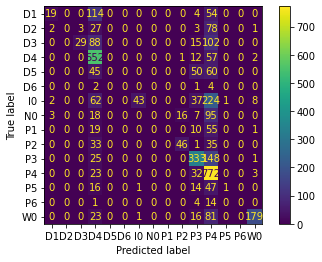

In [197]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(model1, X_val_vect, y_val)  
plt.show()

### XGB Classifier

In [198]:
from xgboost import XGBClassifier
model3 = XGBClassifier()

In [199]:
model3.fit(X_train_vect, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [200]:
y_predict3 = model3.predict(X_val_vect)

In [201]:
print('Accuracy score: {}%'.format(accuracy_score(y_val, y_predict3) * 100))
print(20*'-')
print(classification_report(y_val, y_predict3))

Accuracy score: 60.99046610169492%
--------------------
              precision    recall  f1-score   support

          D1       0.58      0.60      0.59       191
          D2       0.53      0.39      0.45       114
          D3       0.55      0.45      0.50       234
          D4       0.72      0.75      0.73       624
          D5       0.46      0.48      0.47       155
          D6       0.50      0.43      0.46         7
          I0       0.43      0.38      0.40       377
          N0       0.33      0.14      0.20       139
          P1       0.37      0.24      0.29        85
          P2       0.70      0.69      0.69       115
          P3       0.60      0.70      0.65       507
          P4       0.62      0.74      0.67       830
          P5       0.41      0.43      0.42        79
          P6       0.40      0.11      0.17        19
          W0       0.89      0.75      0.81       300

    accuracy                           0.61      3776
   macro avg       0.54 

In [203]:
print(confusion_matrix(y_val, y_predict3))

[[115   5   4  33   5   0   8   1   1   0   5   7   5   1   1]
 [  5  45  14   6   0   0   3   8   1   2  10  19   1   0   0]
 [  4   2 106  30  13   0  13   2   4   0  22  36   1   1   0]
 [ 25   6  16 468  18   2  24   1   5   3  13  34   4   0   5]
 [  4   2   9  12  74   0   8   1   0   0  25  17   2   0   1]
 [  0   0   0   2   0   3   1   0   0   0   0   0   0   0   1]
 [  9   8   3  29  14   0 142   4   7   2  35 102  11   0  11]
 [  7   1   2   5   2   0  14  20   2  23  11  47   4   0   1]
 [  3   1   7  15   4   0   9   1  20   0  11  12   2   0   0]
 [  0   1   1   9   0   1   5  11   0  79   0   6   0   0   2]
 [  6   4   7  13  18   0  17   1   7   2 357  63  10   0   2]
 [  7   8  23  17  11   0  49   7   5   0  82 613   4   0   4]
 [  6   1   0   5   0   0   7   1   1   2   6  15  34   1   0]
 [  6   0   0   1   0   0   0   0   0   0   4   2   4   2   0]
 [  1   1   0   7   3   0  32   3   1   0  13  14   0   0 225]]


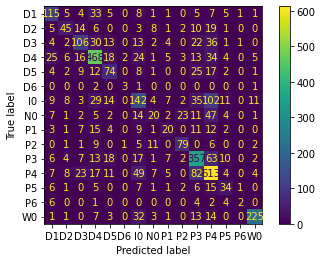

In [202]:
plot_confusion_matrix(model3, X_val_vect, y_val)  
plt.show()

### Random forest classifier

In [204]:
from sklearn.ensemble import RandomForestClassifier
model4 = RandomForestClassifier()

In [205]:
model4.fit(X_train_vect, y_train)

RandomForestClassifier()

In [206]:
y_predict4 = model4.predict(X_val_vect)

In [207]:
print('Accuracy score: {}%'.format(accuracy_score(y_val, y_predict4) * 100))
print(20*'-')
print(classification_report(y_val, y_predict4))

Accuracy score: 60.54025423728814%
--------------------
              precision    recall  f1-score   support

          D1       0.58      0.49      0.53       191
          D2       0.56      0.31      0.40       114
          D3       0.69      0.35      0.46       234
          D4       0.62      0.81      0.70       624
          D5       0.56      0.43      0.48       155
          D6       0.50      0.29      0.36         7
          I0       0.48      0.33      0.39       377
          N0       0.34      0.11      0.16       139
          P1       0.55      0.14      0.22        85
          P2       0.63      0.71      0.67       115
          P3       0.58      0.71      0.64       507
          P4       0.59      0.79      0.67       830
          P5       0.58      0.42      0.49        79
          P6       0.00      0.00      0.00        19
          W0       0.85      0.74      0.79       300

    accuracy                           0.61      3776
   macro avg       0.54 

In [208]:
print(confusion_matrix(y_val, y_predict4))

[[ 94   2   2  59   1   0   4   2   1   0   5  18   0   1   2]
 [  5  35  10  12   0   0   4   8   0   0   9  29   0   0   2]
 [  3   0  81  54  10   0   6   0   1   0  29  49   0   0   1]
 [ 15   7  10 505  12   1  23   1   0   4  15  26   2   0   3]
 [  2   2   4  27  66   0   6   0   0   2  33  12   0   0   1]
 [  0   0   0   4   0   2   1   0   0   0   0   0   0   0   0]
 [ 10   6   4  42   9   0 124   4   2   2  39 111   7   0  17]
 [ 11   1   0   5   1   1   9  15   2  28   8  57   1   0   0]
 [  3   0   1  18   1   0   8   0  12   2  17  20   2   0   1]
 [  0   1   0   8   0   0   8   6   0  82   1   7   0   0   2]
 [  4   1   1  28   7   0   9   1   1   3 362  81   7   0   2]
 [  8   6   4  24   8   0  32   3   1   3  80 653   0   0   8]
 [  3   1   0  11   0   0   3   1   1   3   5  18  33   0   0]
 [  4   0   0   1   0   0   0   0   0   1   4   4   5   0   0]
 [  1   0   0  11   3   0  24   3   1   0  12  23   0   0 222]]


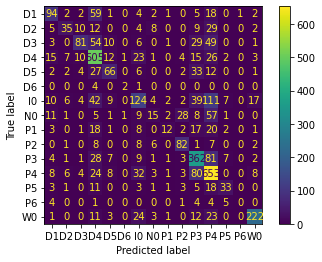

In [209]:
plot_confusion_matrix(model4, X_val_vect, y_val) 
plt.show()